In [1]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.graph_objects as go # gráficos 3D
from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from sklearn.preprocessing import LabelEncoder # transformação de dados
import pingouin as pg # outro modo para obtenção de matrizes de correlações
import emojis # inserção de emojis em gráficos
from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal
from scipy import stats # utilizado na definição da função 'breusch_pagan_test'

In [6]:
# Carrega o dataframe
df_empresas = pd.read_csv('data/empresas.csv', delimiter=',')

# Características das variáveis do dataset
df_empresas.info()

# Estatísticas univariadas
df_empresas.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   empresa        124 non-null    object 
 1   retorno        124 non-null    float64
 2   disclosure     124 non-null    int64  
 3   endividamento  124 non-null    float64
 4   ativos         124 non-null    int64  
 5   liquidez       124 non-null    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 5.9+ KB


,retorno,disclosure,endividamento,ativos,liquidez
count,124.000000,124.000000,124.000000,124.000000,124.000000
mean,46.195484,49.677419,27.734677,3739.064516,12.300000
std,15.075886,31.338059,12.454287,1538.500462,3.141746
min,21.030000,6.000000,1.200000,1851.000000,7.900000
25%,33.840000,18.000000,18.525000,2597.000000,9.300000
50%,44.175000,41.000000,24.950000,3476.000000,12.200000
75%,58.205000,83.000000,34.125000,4458.000000,15.800000
max,86.180000,98.000000,64.900000,9010.000000,17.000000


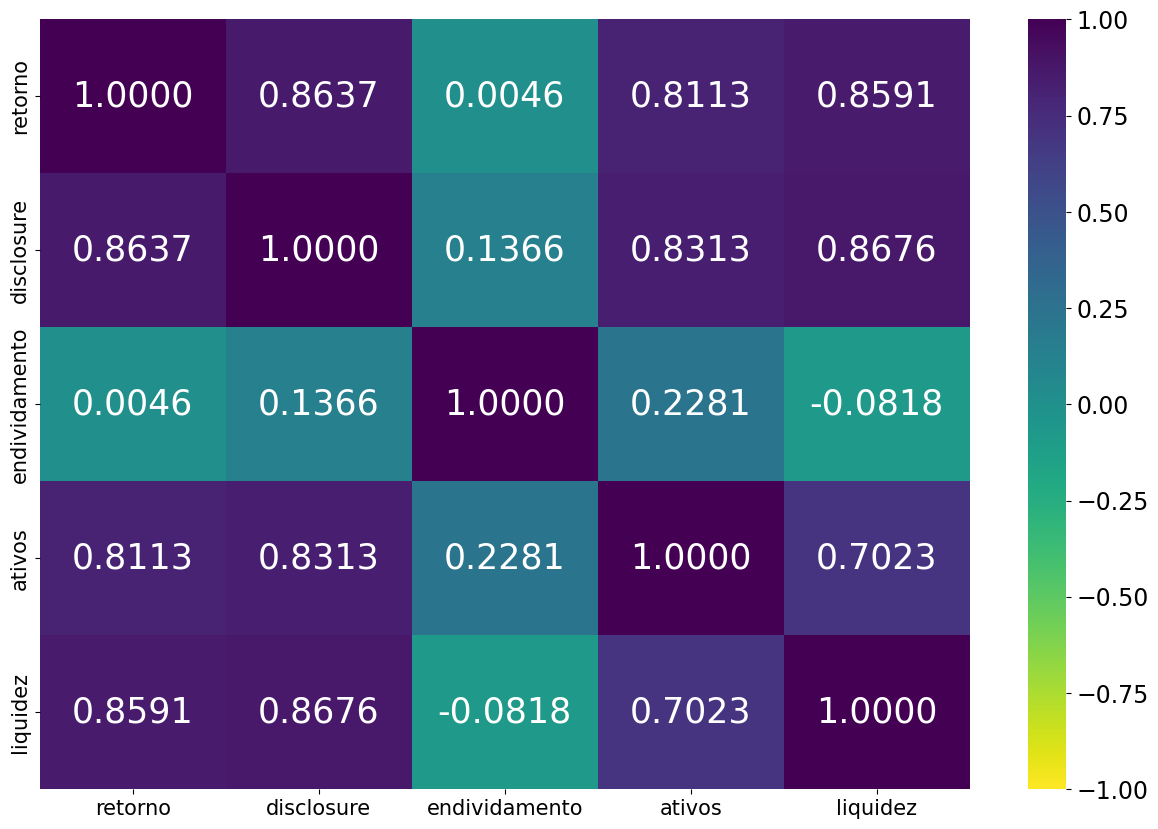

In [7]:
# Matriz de correlações
correlation_matrix = df_empresas.iloc[:,1:6].corr()
correlation_matrix

# Mapa de calor com as correlações entre todas as variáveis quantitativas
plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".4f",
                      cmap=plt.cm.viridis_r,
                      annot_kws={'size': 25}, vmin=-1, vmax=1)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=15)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=15)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=17)
plt.show()

In [8]:
# Matriz de correlações
# Maneira mais elaborada pela função 'rcorr' do pacote 'pingouin'

import pingouin as pg

correlation_matrix2 = pg.rcorr(df_empresas, method='pearson',
                              upper='pval', decimals=4,
                              pval_stars={0.01: '***',
                                          0.05: '**',
                                          0.10: '*'})
correlation_matrix2

c:\Users\guilh\OneDrive\MBA\Machine Learning\Supervisionado\Regressão Linear\regressao_linear\.venv\Lib\site-packages\pingouin\correlation.py:1116: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mat_upper = mat_upper.applymap(replace_pval)


,retorno,disclosure,endividamento,ativos,liquidez
retorno,-,***,,***,***
disclosure,0.8637,-,,***,***
endividamento,0.0046,0.1366,-,**,
ativos,0.8113,0.8313,0.2281,-,***
liquidez,0.8591,0.8676,-0.0818,0.7023,-


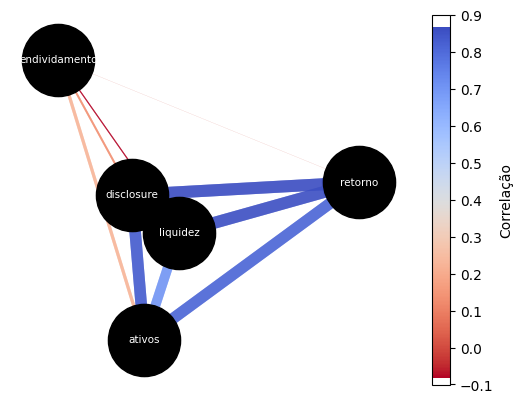

In [9]:
# Diagrama interessante (grafo) que mostra a inter-relação entre as
# variáveis e a magnitude das correlações entre elas

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Criação de um grafo direcionado
G = nx.DiGraph()

# Adição das variáveis como nós do grafo
for variable in correlation_matrix.columns:
    G.add_node(variable)

# Adição das arestas com espessuras proporcionais às correlações
for i, variable1 in enumerate(correlation_matrix.columns):
    for j, variable2 in enumerate(correlation_matrix.columns):
        if i != j:
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) > 0:
                G.add_edge(variable1, variable2, weight=correlation)

# Obtenção da lista de correlações das arestas
correlations = [d["weight"] for _, _, d in G.edges(data=True)]

# Definição da dimensão dos nós
node_size = 2700

# Definição da cor dos nós
node_color = 'black'

# Definição da escala de cores das retas (correspondência com as correlações)
cmap = plt.colormaps.get_cmap('coolwarm_r')

# Criação de uma lista de espessuras das arestas proporcional às correlações
edge_widths = [abs(d["weight"]) * 10 for _, _, d in G.edges(data=True)]

# Criação do layout do grafo com maior distância entre os nós
pos = nx.spring_layout(G, k=0.75)  # k para controlar a distância entre os nós

# Ajuste das posições dos nós das variáveis
pos["retorno"] = (pos["retorno"][0] + 1.8, pos["retorno"][1] + 1.8)
pos["disclosure"] = (pos["disclosure"][0], pos["disclosure"][1] + 1.8)
pos["endividamento"] = (pos["endividamento"][0], pos["endividamento"][1] + 1.8)
pos["ativos"] = (pos["ativos"][0], pos["ativos"][1])
pos["liquidez"] = (pos["liquidez"][0], pos["liquidez"][1] + 1.8)

# Desenho dos nós e das arestas com base nas correlações e espessuras
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=correlations,
                       edge_cmap=cmap, alpha=0.7)

# Adição dos rótulos dos nós
labels = {node: node for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=7.5, font_color='white')

# Ajuste dos limites dos eixos
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")

# Criação da legenda com a escala de cores definida
smp = cm.ScalarMappable(cmap=cmap)
smp.set_array([min(correlations), max(correlations)])
cbar = plt.colorbar(smp, ax=ax, label='Correlação')

# Definição dos ticks da colorbar
cbar.set_ticks(np.arange(round(min(correlations),0) - 0.1,
                         max(correlations) + 0.1, 0.1))

# Exibição do gráfico
plt.show()

<Figure size 2000x1000 with 0 Axes>

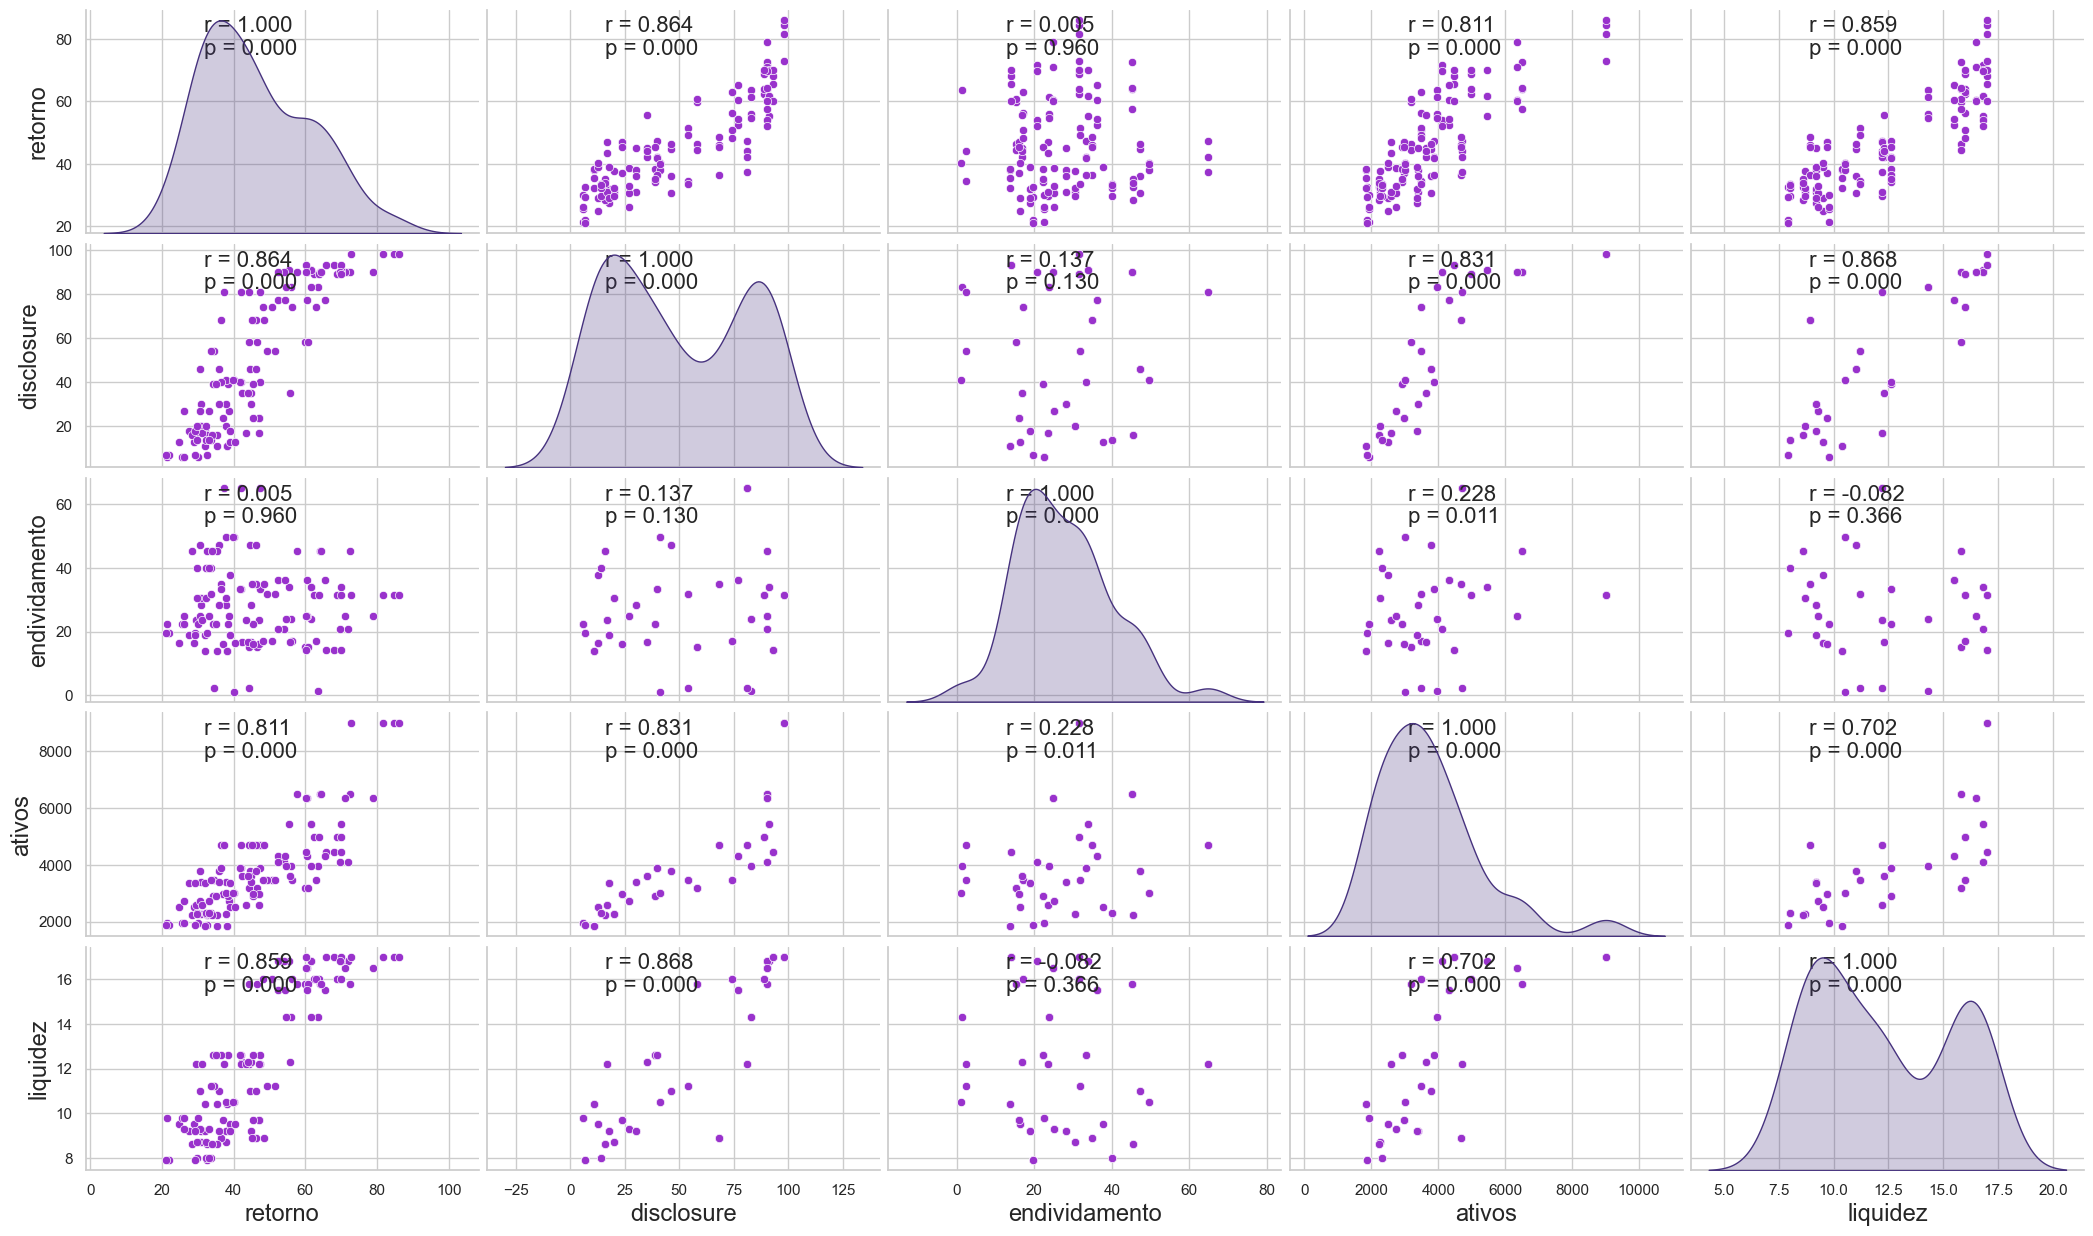

In [10]:
# Distribuições das variáveis, scatters, valores das correlações e
# suas respectivas significâncias

def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(r),
                xy=(.30, .9), xycoords=ax.transAxes, fontsize=16)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.30, .8), xycoords=ax.transAxes, fontsize=16)

# Configuração do gráfico
sns.set_theme(style="whitegrid", palette="viridis")

plt.figure(figsize=(20,10))
graph = sns.pairplot(df_empresas, diag_kind="kde",
                     plot_kws={"color": "darkorchid"},
                     height=2.5, aspect=1.7)
graph.map(corrfunc)
for ax in graph.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=17)
    ax.set_ylabel(ax.get_ylabel(), fontsize=17)
plt.show()

In [11]:
# In[5.5]: Estimando o Modelo de Regressão Múltipla
modelo_empresas = sm.OLS.from_formula('retorno ~ disclosure +\
                                      endividamento + ativos +\
                                          liquidez', df_empresas).fit()

# Parâmetros do 'modelo_empresas'
print(modelo_empresas.summary())

                            OLS Regression Results                            
Dep. Variable:                retorno   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     147.9
Date:                Wed, 07 Aug 2024   Prob (F-statistic):           3.35e-45
Time:                        20:03:53   Log-Likelihood:                -401.07
No. Observations:                 124   AIC:                             812.1
Df Residuals:                     119   BIC:                             826.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.0506      4.080      1.483

**Endividamento é o unico beta que vai ficar de fora do modelo pois não é estatisticamente significante ao nível de significância de 5% (nível de confiança de 95%), p-value (P>|t| > 0.05)**

``Multicolinearidade (correlação forte com outras variáveis), eventualmente implica na exclusão da variável do modelo!``

In [12]:
# Procedimento Stepwise

# Carregamento da função 'stepwise' do pacote 'statstests.process'
# https://stats-tests.github.io/statstests/

from statstests.process import stepwise

# Estimação do modelo por meio do procedimento Stepwise
modelo_step_empresas = stepwise(modelo_empresas, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 retorno ~ Q('disclosure') + Q('endividamento') + Q('ativos') + Q('liquidez')

 Discarding atribute "Q('endividamento')" with p-value equal to 0.08749071283026397 

Estimating model...: 
 retorno ~ Q('disclosure') + Q('ativos') + Q('liquidez')

 Discarding atribute "Q('disclosure')" with p-value equal to 0.065140299543107 

Estimating model...: 
 retorno ~ Q('ativos') + Q('liquidez')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('endividamento')", 'p-value': np.float64(0.08749071283026397)}
{'atribute': "Q('disclosure')", 'p-value': np.float64(0.065140299543107)}

 Model after stepwise process...: 
 retorno ~ Q('ativos') + Q('liquidez') 

                            OLS Regression Results                            
Dep. Variable:                retorno   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method: 

```A Função stepwise executa automaticamente o processo de exclusão de variáveis estatisticamente insignificantes```

In [14]:
# Teste de verificação da aderência dos resíduos à normalidade

# Teste de Shapiro-Wilk (n < 30)
#from scipy.stats import shapiro
#shapiro(modelo_step_empresas.resid)

# Teste de Shapiro-Francia (n >= 30)
# Carregamento da função 'shapiro_francia' do pacote 'statstests.tests'
# https://stats-tests.github.io/statstests/

from statstests.tests import shapiro_francia

# Teste de Shapiro-Francia: interpretação
teste_sf = shapiro_francia(modelo_step_empresas.resid) #criação do objeto 'teste_sf'
teste_sf = teste_sf.items() #retorna o grupo de pares de valores-chave no dicionário
method, statistics_W, statistics_z, p = teste_sf #definição dos elementos da lista (tupla)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 # nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9738705318499362
statistics z  :  2.0934256948868866
p-value  :  0.01815558534418546
Statistics W=0.97387, p-value=0.018156
Rejeita-se H0 - Distribuição não aderente à normalidade


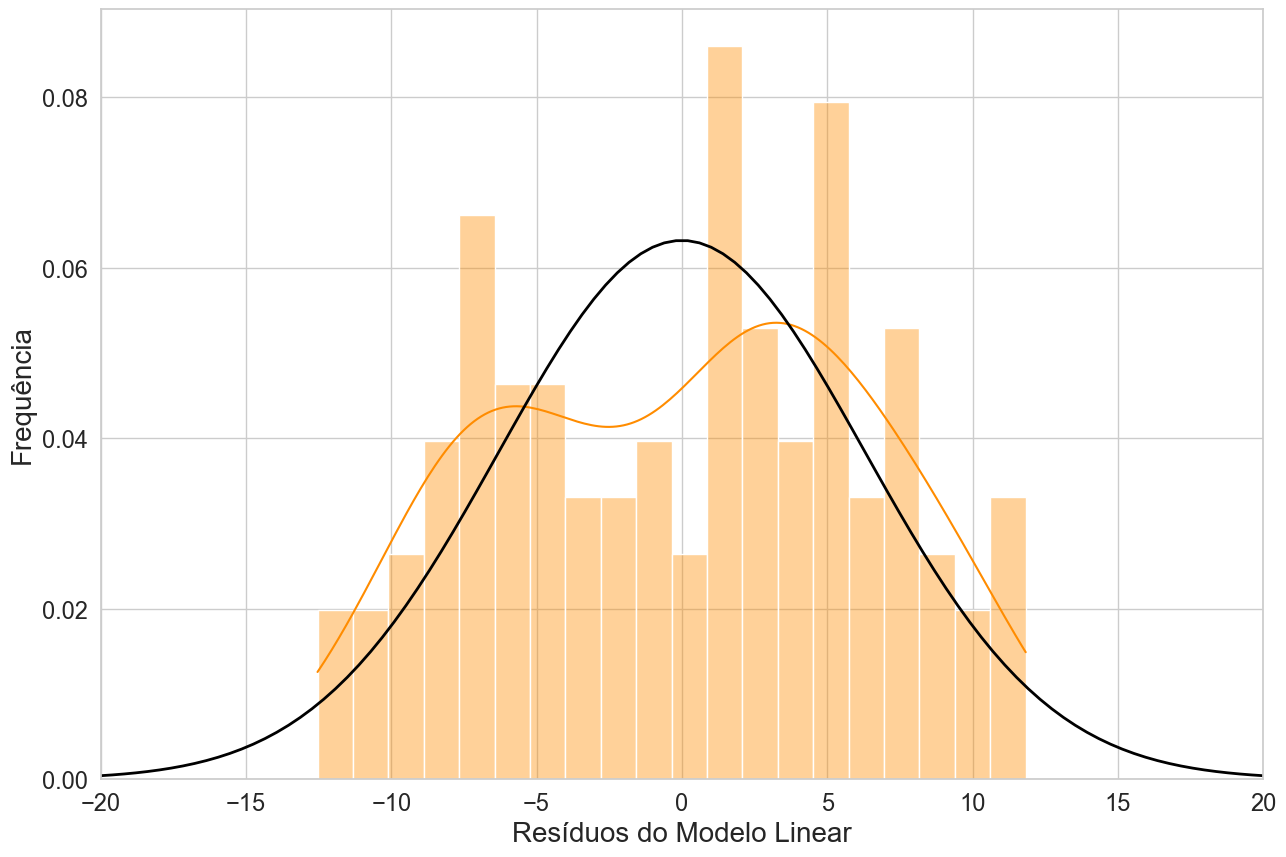

In [15]:
# Plotando os resíduos do 'modelo_step_empresas' e acrescentando
# uma curva normal teórica para comparação entre as distribuições
# Kernel density estimation (KDE) - forma não-paramétrica para estimação da
# função densidade de probabilidade de determinada variável

from scipy.stats import norm

# Calcula os valores de ajuste da distribuição normal
(mu, sigma) = norm.fit(modelo_step_empresas.resid)

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.histplot(modelo_step_empresas.resid, bins=20, kde=True, stat="density",
             color='darkorange', alpha=0.4)
plt.xlim(-20, 20)
x = np.linspace(-20, 20, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Linear', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

In [16]:
# Transformação de Box-Cox

# Para o cálculo do lambda de Box-Cox
from scipy.stats import boxcox

# 'yast' é uma variável que traz os valores transformados (Y*)
# 'lmbda' é o lambda de Box-Cox
yast, lmbda = boxcox(df_empresas['retorno'])

print("Lambda: ",lmbda)

Lambda:  -0.022564196695498386


In [17]:
# Inserindo o lambda de Box-Cox no dataset para a estimação de um
# novo modelo

df_empresas['bc_retorno'] = yast
df_empresas

# Verificação do cálculo, apenas para fins de aprendizado utilizando a formula
df_empresas['bc_retorno2'] = ((df_empresas['retorno'])**(lmbda) - 1) / (lmbda)
df_empresas

# Removendo a coluna criada acima
del df_empresas['bc_retorno2']

In [18]:
# Estimando um novo modelo múltiplo com variável dependente
# transformada por Box-Cox

modelo_bc = sm.OLS.from_formula('bc_retorno ~ disclosure +\
                                endividamento + ativos +\
                                    liquidez', df_empresas).fit()

# Parâmetros do 'modelo_bc', ou seja, com aplicação da transformação
# por Box-Cox
print(modelo_bc.summary())

                            OLS Regression Results                            
Dep. Variable:             bc_retorno   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     119.9
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           8.80e-41
Time:                        22:29:40   Log-Likelihood:                 74.552
No. Observations:                 124   AIC:                            -139.1
Df Residuals:                     119   BIC:                            -125.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.8844      0.088     32.752

In [19]:
# Aplicando o procedimento Stepwise no 'modelo_bc"

modelo_step_empresas_bc = stepwise(modelo_bc, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 bc_retorno ~ Q('disclosure') + Q('endividamento') + Q('ativos') + Q('liquidez')

 Discarding atribute "Q('endividamento')" with p-value equal to 0.2596629429592793 

Estimating model...: 
 bc_retorno ~ Q('disclosure') + Q('ativos') + Q('liquidez')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('endividamento')", 'p-value': np.float64(0.2596629429592793)}

 Model after stepwise process...: 
 bc_retorno ~ Q('disclosure') + Q('ativos') + Q('liquidez') 

                            OLS Regression Results                            
Dep. Variable:             bc_retorno   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     159.0
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           1.21e-41
Time:                        22:29:55   Lo

*A variável 'disclosure' retorna ao modelo na forma funcional não linear!*

Quais Razões levam uma variável a ser excluída pelo seu p-value no teste T associada ao seu parametro beta no modelo multivariado:

1. Individualmente ela já não passa;
2. Ela não passa por um problema de multicolinearidade com outras variáveis preditoras (disclosure);
3. Uso incorreto da forma funcional (linear ou não linear, também foi o caso do disclosure, depois de aplicar o Box-Cox ele voltou).

In [20]:
# Verificando a normalidade dos resíduos do 'modelo_step_empresas_bc'

# Teste de Shapiro-Francia: interpretação
teste_sf = shapiro_francia(modelo_step_empresas_bc.resid) #criação do objeto 'teste_sf'
teste_sf = teste_sf.items() #retorna o grupo de pares de valores-chave no dicionário
method, statistics_W, statistics_z, p = teste_sf #definição dos elementos da lista (tupla)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 # nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9870486153080116
statistics z  :  0.6866621304564735
p-value  :  0.24614783310611593
Statistics W=0.98705, p-value=0.246148
Não se rejeita H0 - Distribuição aderente à normalidade


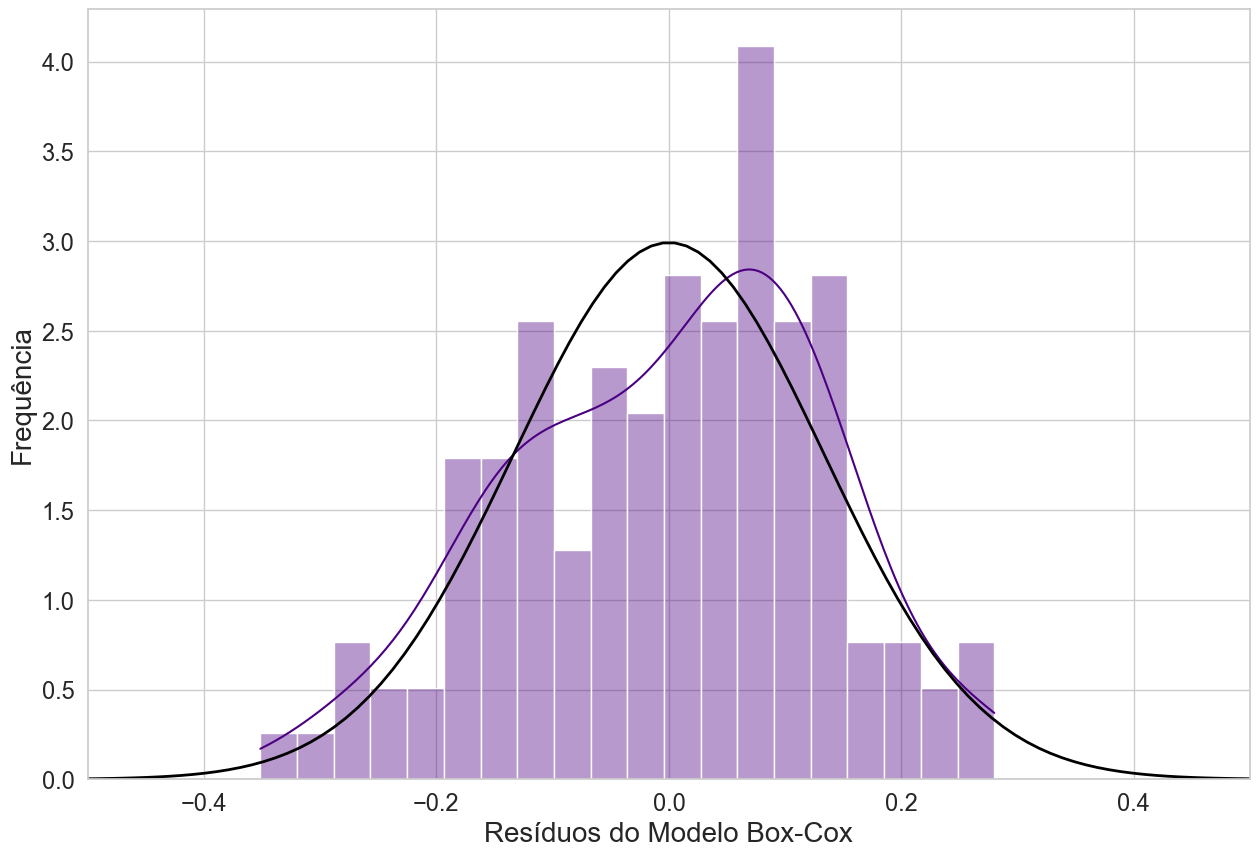

In [21]:
# Plotando os novos resíduos do 'modelo_step_empresas_bc' e
# acrescentando uma curva normal teórica para comparação entre as distribuições

from scipy.stats import norm

# Calcula os valores de ajuste da distribuição normal
(mu, sigma) = norm.fit(modelo_step_empresas_bc.resid)

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.histplot(modelo_step_empresas_bc.resid, bins=20, kde=True, stat="density",
             color='indigo', alpha=0.4)
plt.xlim(-0.5, 0.5)
x = np.linspace(-0.5, 0.5, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Box-Cox', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

In [22]:
# Resumo dos dois modelos obtidos pelo procedimento Stepwise
# (linear e com Box-Cox)

summary_col([modelo_step_empresas, modelo_step_empresas_bc],
            model_names=["STEPWISE","STEPWISE BOX-COX"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs))
        })

# ATENÇÃO!!! OS PARÂMETROS NÃO SÃO DIRETAMENTE COMPARÁVEIS!

,STEPWISE,STEPWISE BOX-COX
Intercept,-2.5348,2.8275***
,(2.3409),(0.0725)
Q('ativos'),0.0040***,0.0000***
,(0.0005),(0.0000)
Q('liquidez'),2.7391***,0.0398***
,(0.2575),(0.0078)
Q('disclosure'),,0.0031***
,,(0.0010)
R-squared,0.8234,0.7990
R-squared Adj.,0.8205,0.7940


In [23]:
# Fazendo predições com o 'modelo_step_empresas_bc'
# Qual é o valor do retorno, em média, para 'disclosure' igual a 50,
#'liquidez' igual a 14 e 'ativos' igual a 4000?

modelo_step_empresas_bc.predict(pd.DataFrame({'const':[1],
                                              'disclosure':[50],
                                              'ativos':[4000],
                                              'liquidez':[14]}))

0    3.702015
dtype: float64

In [24]:
# Cálculo manual do fitted value, variável dependente Y

(3.702016 * lmbda + 1) ** (1 / lmbda)

np.float64(47.742648034829074)

In [25]:
# Salvando os fitted values de 'modelo_step_empresas' e
# 'modelo_step_empresas_bc' para comparação dos modelos

df_empresas['yhat_step_empresas'] = modelo_step_empresas.fittedvalues
df_empresas['yhat_step_empresas_bc'] = (modelo_step_empresas_bc.fittedvalues
                                        * lmbda + 1) ** (1 / lmbda)

# Visualizando os dois fitted values dos modelos 'modelo_step_empresas' e
#'modelo_step_empresas_bc' no dataset
df_empresas[['empresa','retorno','yhat_step_empresas','yhat_step_empresas_bc']]

,empresa,retorno,yhat_step_empresas,yhat_step_empresas_bc
0,Adidas,63.67,52.590460,54.072393
1,BASF,55.49,65.403203,66.165319
2,Bayer,52.42,57.325376,56.706216
3,BSH,54.00,60.009319,62.161048
4,Bosch,68.01,61.960912,64.337230
...,...,...,...,...
119,DuPont,39.85,38.276327,38.078000
120,ExxonMobil,44.16,45.724617,41.446024
121,FedEx,45.38,35.988530,34.685312
122,Ford Motors,45.25,40.711577,41.929545


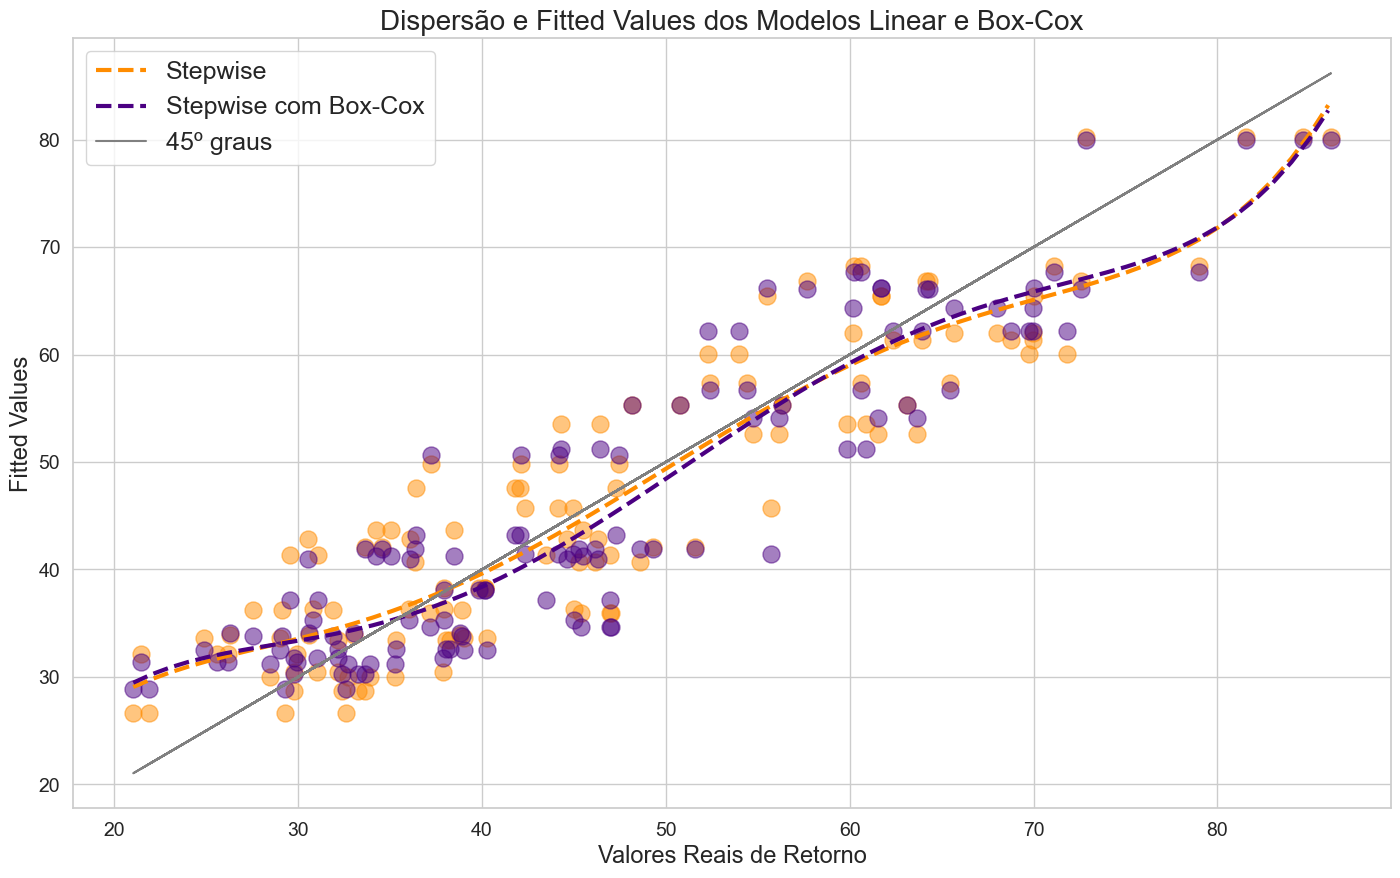

In [26]:
# Ajustes dos modelos: valores previstos (fitted values) X valores reais

from scipy.optimize import curve_fit

def objective(x, a, b, c, d, e, f):
    return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

xdata = df_empresas['retorno']
ydata_linear = df_empresas['yhat_step_empresas']
ydata_bc = df_empresas['yhat_step_empresas_bc']

plt.figure(figsize=(17,10))

popt, _ = curve_fit(objective, xdata, ydata_linear)
a, b, c, d, e, f = popt
x_line = np.arange(min(xdata), max(xdata), 1)
y_line = objective(x_line, a, b, c, d, e, f)
plt.plot(x_line, y_line, '--', color='darkorange', linewidth=3)

popt, _ = curve_fit(objective, xdata, ydata_bc)
a, b, c, d, e, f = popt
x_line = np.arange(min(xdata), max(xdata), 1)
y_line = objective(x_line, a, b, c, d, e, f)
plt.plot(x_line, y_line, '--', color='indigo', linewidth=3)

plt.plot(xdata,xdata, color='gray', linestyle='-')
plt.scatter(xdata,ydata_linear, alpha=0.5, s=150, color='darkorange')
plt.scatter(xdata,ydata_bc, alpha=0.5, s=150, color='indigo')
plt.title('Dispersão e Fitted Values dos Modelos Linear e Box-Cox',
          fontsize=20)
plt.xlabel('Valores Reais de Retorno', fontsize=17)
plt.ylabel('Fitted Values', fontsize=17)
plt.legend(['Stepwise','Stepwise com Box-Cox','45º graus'], fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()